## Imports

In [1]:
#!pip install plotly

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.tools as tls

init_notebook_mode(connected=True)
# tls.set_credentials_file(username='owencallen', api_key='QSH0OAhYDmgvVKQaZ11M')

## Load data

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
spray_df = pd.read_csv('../input/spray.csv')

## 1st look at DataFrames

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [4]:
train_df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [5]:
train_df = train_df[['Date', 'Species', 'Trap', 'Latitude', 'Longitude','NumMosquitos', 'WnvPresent']]
train_df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


In [6]:
test_df.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [7]:
test_df = test_df[['Date', 'Species', 'Trap', 'Latitude', 'Longitude']]
test_df.head()

,Date,Species,Trap,Latitude,Longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991


In [8]:
spray_df.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

In [9]:
spray_df = spray_df[['Date', 'Latitude', 'Longitude']]
spray_df.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [10]:
train_df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Why are PIPIENS/RESTUANS not split?

In [11]:
train_df['Trap'].value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

In [12]:
test_df['Trap'].value_counts().head()

T009    1528
T035    1520
T900    1468
T002     857
T008     822
Name: Trap, dtype: int64

## Distibution of dates and observastions

In [13]:
train_dates = train_df['Date'].value_counts()
train_dates.sort_index(inplace=True)
train_dates.index = pd.to_datetime(train_dates.index)

In [14]:
test_dates = test_df['Date'].value_counts()
test_dates.sort_index(inplace=True)
test_dates.index = pd.to_datetime(test_dates.index)

In [15]:
spray_dates = spray_df['Date'].value_counts()
spray_dates.sort_index(inplace=True)
spray_dates.index = pd.to_datetime(spray_dates.index)

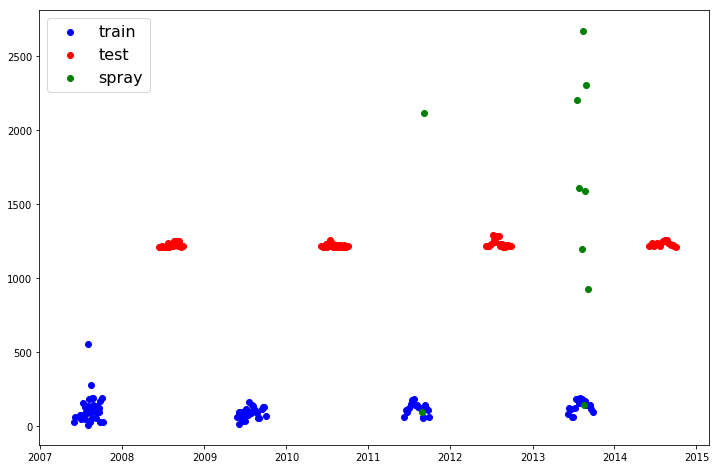

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(train_dates.index, train_dates, c='b')
plt.scatter(test_dates.index, test_dates, c='r')
plt.scatter(spray_dates.index, spray_dates, c='g')
plt.legend(['train','test','spray'], fontsize = 16, loc = 2);

In [17]:
train_2013 = train_df[train_df['Date'].str.contains('2013')]

spray_2013 = spray_df[spray_df['Date'].str.contains('2013')]

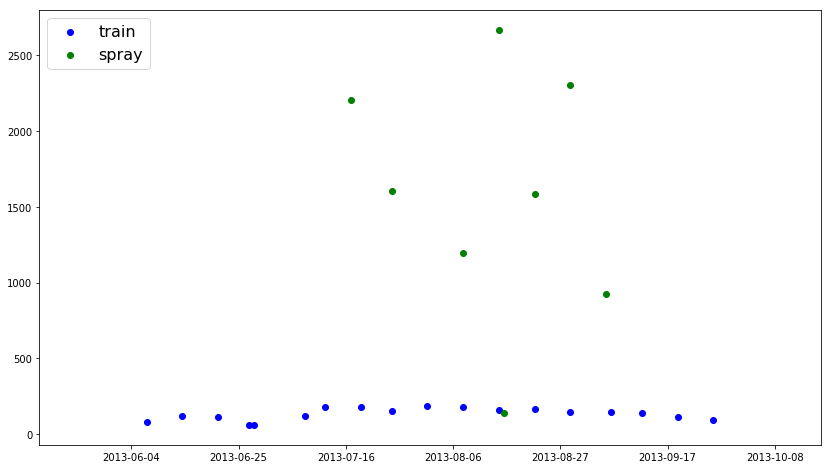

In [18]:
dates_2013 = pd.to_datetime(train_2013['Date'].value_counts().index)

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(dates_2013, train_2013['Date'].value_counts(), c='b')
plt.scatter(pd.to_datetime(spray_2013['Date'].value_counts().index), spray_2013['Date'].value_counts(), c='g')
plt.legend(['train','spray'], fontsize = 16, loc = 2);

## Aggregated population graphs
First find all traps with at least one observation for each observation date.

In [60]:
def get_species_dfs (train_year):
    traps = train_year['Trap'].value_counts().index.tolist()
    good_traps = []
    for trap in traps:
        number_of_dates = train_year[train_year['Trap'] == trap]['Date'].value_counts().shape[0]
        if number_of_dates>=0:
            good_traps.append(trap)

    train_year_good = train_year[train_year['Trap'].isin(good_traps)]
    
    display(train_year_good['Species'].value_counts())

    both_df = train_year_good[train_year_good['Species'] == 'CULEX PIPIENS/RESTUANS']
    
    restuans_df = train_year_good[train_year_good['Species'] == 'CULEX RESTUANS']

    pipiens_df = train_year_good[train_year_good['Species'] == 'CULEX PIPIENS']
    
    return both_df, restuans_df, pipiens_df

In [72]:
train_year = train_df[train_df['Date'].str.contains('2013')]

In [73]:
both_df, restuans_df, pipiens_df = get_species_dfs(train_year)
# both_df, restuans_df, pipiens_df= get_species_dfs(train_2013)

CULEX PIPIENS/RESTUANS    1114
CULEX RESTUANS             802
CULEX PIPIENS              464
CULEX TERRITANS              8
CULEX SALINARIUS             3
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [74]:
def df_totals (df):
    dates = df['Date'].value_counts().index.tolist()
    dates.sort()
    new_df = pd.DataFrame(columns=['NumMosquitos','WnvPresent'],index=dates)
    for date in dates:
        new_df.loc[date,:] = {
            'NumMosquitos':df[df['Date']==date]['NumMosquitos'].sum(),
            'WnvPresent':df[df['Date']==date]['WnvPresent'].sum()
        }
    new_df.index = pd.to_datetime(new_df.index)
    return new_df
# df_totals(both_df)
display(df_totals(restuans_df).sum())
df_totals(pipiens_df).sum()

NumMosquitos    10859
WnvPresent         28
dtype: int64

NumMosquitos    6597
WnvPresent        87
dtype: int64

In [75]:
both_totals = df_totals(both_df)
restuans_totals = df_totals(restuans_df)
pipiens_totals = df_totals(pipiens_df)

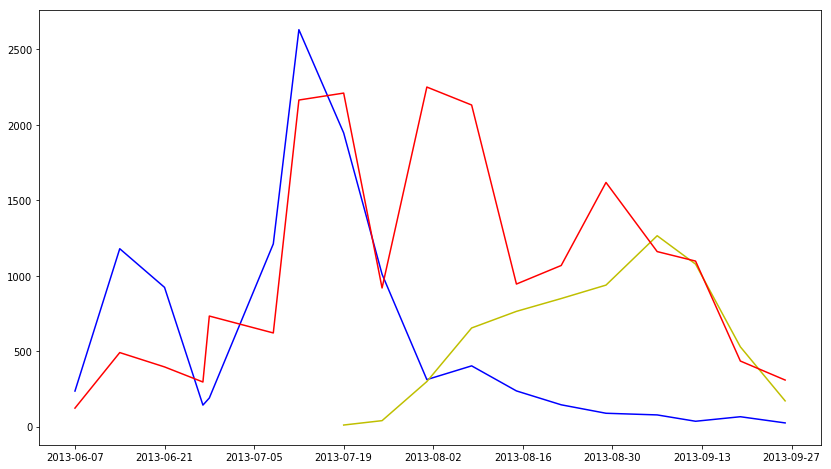

In [76]:
fig, ax = plt.subplots(figsize=(14,8))
plt.plot(restuans_totals.index, restuans_totals['NumMosquitos'], c='b')
plt.plot(pipiens_totals.index, pipiens_totals['NumMosquitos'], c='y')
plt.plot(both_totals.index, both_totals['NumMosquitos'], c='r');
# plt.scatter(pd.to_datetime(spray_2013['Date'].value_counts().index), spray_2013['Date'].value_counts(), c='g');

## Plotly mapping function

In [40]:
def plotly_graph(df):
    data = [{
        'type' : 'scattergeo',
        'locationmode' : 'USA-states',
        'lon' : df['Longitude'],
        'lat' : df['Latitude'],
        'marker' : {
            'size' : 12,
            'autocolorscale' : False,
            'colorscale' : 'custom-colorscale',
            'color' : df['NumMosquitos'], #target being measured
            'colorbar' : {
                'title' : 'Mosquitos present'
            }
        }
    }]

    layout = {
        'title' : 'Species sightings in Chicago',
        'geo' : {
#             'scope' : 'usa',
            'projection' : {'type' : 'albers usa'},
            'showland' : True,
            'landcolor' : 'rgb(250,250,250)',
            'subunitcolor' : 'rgb(210,210,210)',
            'contrycolor' : 'rgb(200,200,200)',
            'contrywidth' : 0.5, 
            'subunitwidth' : 0.5,
            'lonaxis': { 'range': [-86, -88] },
            'lataxis': { 'range': [40, 42] }
        }
    }

    fig = {
        'data':data,
        'layout':layout
    }
    
    return fig

In [22]:
df = train_df[train_df['Date']=='2007-05-29']
fig = plotly_graph(df)
iplot(fig, validate = False)#, filename='d3-Species-map')

In [27]:
df = train_df[train_df['Date']=='2007-05-29']
fig = plotly_graph(df)
iplot(fig, validate = False, filename='d3-Species-map')

In [28]:
df = train_df
fig = plotly_graph(df)
iplot(fig, validate = False, filename='d3-Species-map')